![Deep Learning for Scientists in a hurry](./fig/Title.png)

In [1]:
!nvidia-smi

Mon Jul 24 22:41:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P6000                    Off| 00000000:37:00.0 Off |                  Off |
| 26%   17C    P8                7W / 250W|     70MiB / 24576MiB |      6%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!env | grep SIN

SINGULARITY_NAME=NGC_MXNet_22.09-py3.sif
SINGULARITY_ENVIRONMENT=/.singularity.d/env/91-environment.sh
SINGULARITY_CONTAINER=/shared/containers/NGC_MXNet_22.09-py3.sif
MD_SINGULARITY=/shared/software/singularity/3.7.0
SINGULARITY_BIND=
SINGULARITY_COMMAND=exec


In [3]:
%load_ext watermark

In [4]:
%watermark

Last updated: 2023-07-24T22:41:44.883541-04:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.5.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 3.10.0-1160.24.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit



In [5]:
import os
import time
start = time.time()
chapter_number = 6
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [6]:
import argparse, time, logging, random, math

import PIL

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms

In [7]:
%watermark -iv

numpy     : 1.22.4
gluoncv   : 0.7.0
argparse  : 1.1
matplotlib: 3.6.0
PIL       : 9.2.0
mxnet     : 1.9.1
logging   : 0.5.1.2



# Training with CIFAR10 on MXNet

In this notebook, we will be training one popular dataset called CIFAR10.

This notebook is a modified version from the [Official Documentation for MXNet Gluon](https://cv.gluon.ai/build/examples_classification/dive_deep_cifar10.html)


The CIFAR-10 dataset consists of $60000$ $32 \times 32$ colour images in $10$ classes, with $6000$ images per class. There are $50000$ training images and $10000$ test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:

 * airplane										
 * automobile										
 * bird										
 * cat										
 * deer										
 * dog										
 * frog										
 * horse										
 * ship										
 * truck										

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, and things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.


## Network Structure



Here we pick a simple yet well-performing and still small structure, ``cifar_resnet20_v1``.
This is a residual Network with 20 layers

In [8]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

In [9]:
# Get the model CIFAR_ResNet20_v1, with 10 output classes, without pre-trained weights
net = get_model('cifar_resnet20_v1', classes=10)
net.initialize(mx.init.Xavier(), ctx = ctx)

[22:41:52] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


MXNetError: Traceback (most recent call last):
  File "../include/mxnet/base.h", line 470
CUDA: Check failed: e == cudaSuccess (805 vs. 0) : MPS client failed to connect to the MPS control daemon or the MPS server

In [10]:
net

CIFARResNetV1(
  (features): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, act_type=None, bn_group=1, xbuf_ptr=0, in_channels=None)
    (2): HybridSequential(
      (0): CIFARBasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(16 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, act_type=None, bn_group=1, xbuf_ptr=0, in_channels=None)
          (2): Activation(relu)
          (3): Conv2D(16 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, act_type=None, bn_group=1, xbuf_ptr=0, in_channels=None)
        )
      )
      (1): CIFARBasicBlockV1(
        (body): HybridSequential(
     

## Looking at some of the images in CIFAR10

In [11]:
training_data = gluon.data.vision.CIFAR10(root="./data",train=True)

In [12]:
num_images = 120
tens = [ training_data[i][0] for i in range(num_images) ]

In [13]:
tens[0].shape

(32, 32, 3)

In [14]:
def tensor_to_image(tensor):
    tensor = (1-tensor)*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor, mode='RGB').resize((64,64)) # Doubling the size for visualization

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

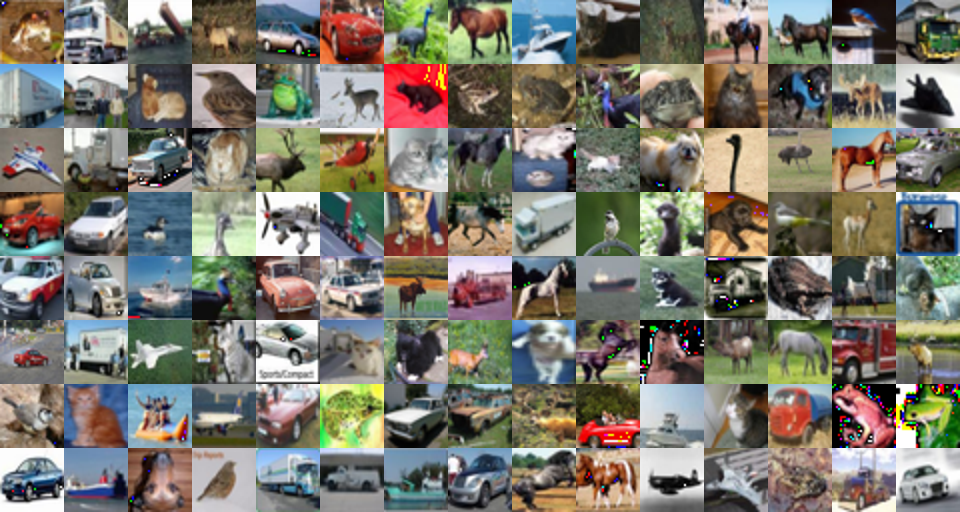

In [15]:
imgs = [ tensor_to_image(tens[i].asnumpy()) for i in range(num_images) ]

image_grid(imgs, 8,15)

## Data Augmentation and Data Loader

Data augmentation is a common technique used for training. It is
base on the assumption that, for the same object, photos under different
composition, lighting condition, or color should all yield the same prediction.


We want to teach this invariance to our model, by playing "augmenting"
input image. Our augmentation transforms the image with
resizing, cropping, flipping and other techniques.

With ``Gluon``, we can create our transform function as following:



In [16]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
    # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

You may have noticed that most of the operations are randomized. This in effect
increases the number of different images the model sees during training.
The more data we have, the better our model generalizes over
unseen images.

On the other hand, when making prediction, we would like to remove all
random operations in order to get a deterministic result. The transform
function for prediction is:



In [17]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

Note that it is important to keep the normalization step, since the
model only works well on inputs from the same distribution.

With the transform functions, we can define data loaders for our
training and validation datasets.



In [18]:
# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 8
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(root="./data",train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

# Set train=False for validation data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(root="./data",train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Optimizer, Loss and Metric

Optimizer improves the model during training. Here we use the popular
Nesterov accelerated gradient descent algorithm.



In [19]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [80, 160, np.inf]

# Nesterov accelerated gradient descent
optimizer = 'nag'
# Set parameters
optimizer_params = {'learning_rate': 0.1, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

RuntimeError: Parameter 'cifarresnetv10_dense0_bias' has not been initialized

In the above code, ``lr_decay`` and ``lr_decay_epoch`` are not directly
used in ``trainer``. One important idea in model training is to
gradually decrease learning rate. This means the optimizer takes large
steps at the beginning, but step size becomes smaller and smaller in time.

Our plan sets the learning rate to 0.1 at the beginning, then
divide it by 10 at the 80-th epoch, then again at the 160-th epoch.
We'll use `lr_decay_epoch` in the main training loop for this purpose.

In order to optimize our model, we need a loss function.
In essence, loss functions compute the difference between predictions and the
ground-truth as a measure of model performance.
We can then take the gradients of the loss w.r.t. the weights.
Gradients points the optimizer to the direction weights should move to
improve model performance.

For classification tasks, we usually use softmax cross entropy as the
loss function.



In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Metrics are similar to loss functions, but they are different in the
following aspects:

-  Metric is how we evaluate model performance. Each metric is related to a
   specific task, but independent from the model training process.
-  For classification, we usually only use one loss function to train
   our model, but we can have several metrics for evaluating
   performance.
-  Loss function can be used as a metric, but sometimes its values are hard
   to interpretate. For instance, the concept "accuracy" is
   easier to understand than "softmax cross entropy"

For simplicity, we use accuracy as the metric to monitor our training
process. Besides, we record metric values, and will print them at the
end of training.



In [ ]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

## Validation

Validation dataset provides us a way of monitoring the training process.
We have labels for validation data, but they are held out during training.
Instead, we use them to evaluate the models performance on unseen data
and prevent overfitting.



In [ ]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

In order to evaluate performance, we need a metric. Then, we loop
through the validation data and predict with our model.
We'll run this function at the end of every epoch to show improvement.
over the last epoch.

## Training

After all the preparations, we can finally start training!
Following is the script.

<div class="alert alert-info"><h4>Note</h4><p>In order to finish the tutorial quickly, we only train for 20 epochs.
  In your experiments, we recommend setting ``epochs=240``.</p></div>



In [ ]:
epochs = 20
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

# We can plot the metric scores with:

train_history.plot()

If you trained the model for 240 epochs, the plot may look like:

![Normal Training](./fig/normal_training.png)

We can better observe the process of model training with plots.
For example, one may ask what will happen if there's no data augmentation:

![Overfitting](./fig/overfitting.png)

We can see that training error is much lower than validation error.
After the model reaches 100\% accuracy on training data,
it stops improving on validation data.
These two plots evidently demonstrates the importance of data augmentation.

## Model Saving and Loading

After training, we usually want to save it for later use.
This is simply done with:



In [ ]:
net.save_parameters('./output/dive_deep_cifar10_resnet20_v2.params')

Next time if you need to use it, just run



In [ ]:
net.load_parameters('./output/dive_deep_cifar10_resnet20_v2.params', ctx=ctx)

---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfelow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelein Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

In [ ]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [ ]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')